In [201]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from einops import rearrange
from einops.layers.torch import Rearrange

from typing import Optional

from dataclasses import dataclass
from simple_parsing.helpers import Serializable
import time
import numpy as np
## Functions

def build_complex_rope_cache(dim: int, seq_len: int, theta: float) -> torch.Tensor:
    """
    Compute cache for RoPE and store on device with complex dtype. 
    It speeds up computation.
    Return: [T, dim//2]
    """
    
    freqs = 1.0 / (theta ** (torch.arange(0, dim, 2).float() / dim))
    t = torch.arange(seq_len)  
    freqs = torch.outer(t, freqs).float()
    cache = torch.polar(torch.ones_like(freqs), freqs) 
    cache.requires_grad = False
    return cache

def apply_rope(x: torch.Tensor, rope: torch.Tensor):
    """
    Now, we do not cut rope cache.  You have to cut outside.
    x - [b, t, n_h, dim] 
    rope(freqs_cis):  [T, dim//2] or [B, T, dim//2]
    """
    T = x.size(1)
    len_rope = len(rope.shape)
    
    if len_rope == 2:
        rope = rope[:T]
    else:
        rope = rope[:, :T]

    rope = rope.unsqueeze(-2) # [B, T, 1, dim//2] or [T, 1, dim//2]

    # b, t, n_h, dim - > (b, t, n_h, dim/2, 2)
    x_ = torch.view_as_complex(x.float().reshape(*x.shape[:-1], -1, 2))    

    # (b, t, n_h, dim/2, 2) * t, 1, dim/2
    x_out = torch.view_as_real(x_ * rope).flatten(3)
    return x_out.type_as(x)

def build_advanced_causal_mask(block_size, tok_per_time):
    """
    Return mask in bool dtype, where
        True - include in attention 
        False - don't include.   
    """

    mask = torch.ones(block_size, block_size)
    mask = torch.tril(mask)

    S = torch.ones(tok_per_time, tok_per_time)

    for i in range(0, block_size, tok_per_time):
        lp, rp = i, i + tok_per_time
        mask[lp:rp, lp:rp] = S
    
    causal_mask = mask
    causal_mask = causal_mask.to(torch.bool)
    return causal_mask

## Blocks.

class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()

        self.w1 = nn.Linear(config.dim, config.hidden_dim, bias=False)
        self.w2 = nn.Linear(config.hidden_dim, config.dim, bias=False)
        self.w3 = nn.Linear(config.dim, config.hidden_dim, bias=False)

    def forward(self, x) -> torch.Tensor:
        return self.w2(nn.functional.silu(self.w1(x)) * self.w3(x))

class CausalSelfAttention(nn.Module): 
    """
    Simple Multi head attention with einops and F.scaled_dot_product_attention.
    """
    def __init__(self, config, is_causal=True):

        super().__init__()

        assert config.n_heads == config.n_kv_heads, "n_heads should be equal n_kv_heads"

        self.n_heads = config.n_heads
        self.n_kv_heads = config.n_heads # for simplicity we use vanilla transformer.
        self.repeats = self.n_heads // self.n_kv_heads
        self.head_dim = config.head_dim

        self.qw = nn.Linear(config.dim, config.head_dim * config.n_heads, bias=False)
        self.kw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)
        self.vw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)

        self.project = nn.Linear(config.head_dim * config.n_heads, config.dim, bias=False)

    def forward(self, x, attn_mask, rope, kv_cache=None):
        B, T, C = x.size() # b, t, c*h        
        q, k, v = self.qw(x), self.kw(x), self.vw(x) 

        # split by n_heads.
        q = rearrange(q, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        k = rearrange(k, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        v = rearrange(v, 'b t (nh c) -> b t nh c', b=B, t=T, nh=self.n_heads, c=self.head_dim)

        if rope is not None:
            q = apply_rope(q, rope)
            k = apply_rope(k, rope)

        if attn_mask is not None:
            t_q, t_k = q.size(1), k.size(1)
            attn_mask = attn_mask[..., -t_q:, -t_k:]

        q = q.transpose(1, 2)  # (B, nh, T, c)
        k = k.transpose(1, 2)  # (B, nh, T, c)
        v = v.transpose(1, 2)  # (B, nh, T, c)
        
        res = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask)  

        res = rearrange(res, 'b nh t c -> b t (nh c)', b=B, t=T, nh=self.n_heads, c=self.head_dim)
        res = self.project(res)

        return res
    
class CausalCrossAttention(nn.Module): 
    """
    Simple Multi head attention with einops and F.scaled_dot_product_attention.
    """
    def __init__(self, config, is_causal=True):

        super().__init__()

        assert config.n_heads == config.n_kv_heads, "n_heads should be equal n_kv_heads"

        self.n_heads = config.n_heads
        self.n_kv_heads = config.n_heads # for simplicity we use vanilla transformer.
        self.repeats = self.n_heads // self.n_kv_heads

        self.qw = nn.Linear(config.dim, config.head_dim * config.n_heads, bias=False)
        self.kw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)
        self.vw = nn.Linear(config.dim, config.head_dim * config.n_kv_heads, bias=False)

        self.project = nn.Linear(config.head_dim * config.n_heads, config.dim, bias=False)
        # self.block_size = config.block_size

        self.kv_cache = None

    def forward(self, x, context, attn_mask=None, use_kv_cache=None):
        """
        context should have the same dim as x vectors. 
        context seqlen >> x seqlen
        """
        B, T, C = x.size() # b, t, c*h 
        q, k, v = self.qw(x), self.kw(context), self.vw(context) 

        # split by n_heads.
        q = rearrange(q, 'b t (nh c) -> b nh t c', nh = self.n_heads)
        k = rearrange(k, 'b t (nh c) -> b nh t c', nh = self.n_heads)
        v = rearrange(v, 'b t (nh c) -> b nh t c', nh = self.n_heads)

        if attn_mask is not None:
            t_q, t_k = q.size(2), k.size(2)
            attn_mask = attn_mask[..., -t_q:, -t_k:]
            
        res = F.scaled_dot_product_attention(q, k, v, attn_mask=attn_mask)  

        res = rearrange(res, 'b h t c -> b t (h c)')
        res = self.project(res)
        return res    

class RMSNorm(torch.nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self.eps = eps
        self.weight = nn.Parameter(torch.ones(dim))

    def _norm(self, x):
        return x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps)

    def forward(self, x):
        output = self._norm(x.float()).type_as(x)
        return output * self.weight

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.ln_1 = RMSNorm(config.dim)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = RMSNorm(config.dim)
        self.mlp = MLP(config)

    def forward(self, x, attn_mask=None, rope=None, kv_cache=False):
        x = x + self.attn(self.ln_1(x), attn_mask, rope, kv_cache=kv_cache) 
        x = x + self.mlp(self.ln_2(x))
        return x
    
class CrossBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.sa_block = Block(config)

        self.ln_1 = nn.LayerNorm(config.dim)
        self.cross_attn = CausalCrossAttention(config)
        self.ln_2 = nn.LayerNorm(config.dim)
        self.mlp = MLP(config)

    def forward(self, x, context, self_attn_mask=None, cross_attn_mask=None, sa_rope=None):
        """
        Block with Cross attention -> Block with Self Attention. 
        """
        # cross attention
        x = x + self.cross_attn(self.ln_1(x), context, attn_mask=cross_attn_mask) 
        x = x + self.mlp(self.ln_2(x))
        
        # self attention
        x = self.sa_block(x, attn_mask=self_attn_mask, rope=sa_rope)

        return x

## Models.
class SimpleEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.transformer = nn.ModuleDict(dict(
            emb = nn.Linear(config.patch_size, config.dim),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layers)]),
            ln_f = nn.LayerNorm(config.dim),
        ))
        n_registers = 4
        self.registers = nn.Parameter(torch.zeros(1, n_registers, config.dim))

        self.precompute_rope_cash = build_complex_rope_cache(dim=self.config.head_dim,
                                                             seq_len=config.block_size+n_registers,
                                                             theta=config.rope_theta)
        
        self.attn_mask = torch.ones(config.block_size, config.block_size).to(torch.bool)
        
        print("Encoder: number of parameters: %.2fM" % (self.get_num_params()/1e6,))
        print('Shape of the rope cache: ', self.precompute_rope_cash.shape)

    def forward(self, x, attn_mask=None, rope_cache=None):
        """
        myo signals with shape: with shape [B, T, C]
        """
        attn_mask = self.attn_mask if attn_mask is None else attn_mask
        rope_cache = self.rope_cache if rope_cache is None else torch.cat([rope_cache, self.rope_cache[-4:]])

        # embedding
        x = self.transformer.emb(x)

        # print(attn_mask.shape)
        p2d = (4,0, 0, 4)
        if len(attn_mask.shape) == 2:
            attn_mask = F.pad(attn_mask[None, :].to(torch.int), p2d, "replicate").to(torch.bool)[0]
        else:
            attn_mask = F.pad(attn_mask.to(torch.int), p2d, "replicate").to(torch.bool)
        
        x = torch.cat([self.registers.expand(x.size(0), -1, -1), x], dim=1)
        for block in self.transformer.h:
            x = block(x, 
                      attn_mask=attn_mask, 
                      rope=rope_cache)
        x = x[:, [0], :]
        x = self.transformer.ln_f(x)
        return x 


    @property
    def dtype(self) -> torch.dtype:
        return next(self.parameters()).dtype

    @property
    def device(self) -> torch.device:
        return next(self.parameters()).device

    @property
    def rope_cache(self) -> torch.Tensor:
        # Just to use proper device.
        if self.precompute_rope_cash.device != self.device:
            self.precompute_rope_cash = self.precompute_rope_cash.to(device=self.device)
        return self.precompute_rope_cash
    
    def get_num_params(self):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params



class SimpleMAE(nn.Module):
    def __init__(self, encoder_config, mae_config):
        super().__init__()
        self.encoder_config = encoder_config
        
        self.encoder = SimpleEncoder(encoder_config)

        self.dim = mae_config.dim

        self.decoder = nn.ModuleDict(dict(
            emb = nn.Linear(encoder_config.dim, mae_config.dim), # connection between them.
            h = nn.ModuleList([Block(mae_config) for _ in range(mae_config.n_layers)]),
        ))

        self.mask_token = nn.Parameter(torch.randn(mae_config.dim))
        self.decoder_pos_emb = nn.Embedding(encoder_config.block_size, mae_config.dim)
        self.to_signals = nn.Linear(mae_config.dim, encoder_config.patch_size)

        print("MAE: number of parameters: %.2fM" % (self.get_num_params()/1e6))

    def get_num_params(self, non_embedding=True):
        n_params = sum(p.numel() for p in self.parameters())
        return n_params

    def get_masking_indices(self, masking_ratio, x):
        b, n_tokens, _ = x.shape

        num_masked = int(masking_ratio * n_tokens)
        rand_indices = torch.rand(b, n_tokens, device = x.device).argsort(dim=-1) # get idxs of random values.
        masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

        masked_indices, _ = torch.sort(masked_indices, dim=1)
        unmasked_indices, _ = torch.sort(unmasked_indices, dim=1)      
        
        return masked_indices, unmasked_indices
    

    def forward(self, x, targets=None, date_info=None, masking_ratio=0.75, return_preds=False):
        """
        Inputs: x with shape -> B, T, C
        """
        b, t, c = x.shape

        ### Preparing attn, rope, masking
        masked_indices, unmasked_indices = self.get_masking_indices(masking_ratio, x) # [b, N]
        
        batch_range = torch.arange(b, device=x.device)[:, None]

        is_padded = (x == 0).all(dim=2)
    
        attn_mask = ~is_padded.unsqueeze(1).repeat(1, x.size(1), 1)
        # attn_mask = ~is_padded.unsqueeze(1) & ~is_padded.unsqueeze(2)
        
        attn_mask_unmasked = attn_mask[batch_range[..., None], unmasked_indices[..., None], unmasked_indices[:, None, :]]
        attn_mask_unmasked = rearrange(attn_mask_unmasked, 'b h w -> b 1 h w')
        
        rope_cache = self.encoder.rope_cache.expand(b, -1, -1)
        rope_cache_unmasked = rope_cache[batch_range, unmasked_indices]
        

        ### ENCODER
        
        tokens = x[batch_range, unmasked_indices]
        print('attn_mask_unmasked', attn_mask_unmasked.shape, attn_mask_unmasked[0])
        plt.imshow(attn_mask_unmasked[0, 0].detach().cpu())
        plt.colorbar()
        
        tokens = self.encoder(tokens, attn_mask=attn_mask_unmasked)
        print('TOKENS AFTER ENCODER', tokens[0])

        ### DECODER 
        attn_mask = rearrange(attn_mask, 'b h w -> b 1 h w')

        unmasked_decoder_tokens = self.decoder.emb(tokens)

        decoder_tokens = torch.zeros(b, t, self.dim, device=x.device, dtype=x.dtype)
        decoder_tokens[batch_range, unmasked_indices] = unmasked_decoder_tokens
        decoder_tokens[batch_range, masked_indices] = self.mask_token

        decoder_pos_emb = self.decoder_pos_emb(torch.cat([unmasked_indices, masked_indices], 1))
        decoder_tokens = decoder_tokens + decoder_pos_emb


        
        for block in self.decoder.h:
            decoder_tokens = block(decoder_tokens, attn_mask)


        pred_tokens = self.to_signals(decoder_tokens)

        ### LOSS: mse on masked and not padded tokens.
        tokens_pred_masked = pred_tokens[batch_range, masked_indices]
        tokens_real_masked = x[batch_range, masked_indices]

        # let's calculate loss on masked and not padded tokens.
        mask_valid = ~is_padded[batch_range, masked_indices]
        loss_tensor = F.mse_loss(tokens_pred_masked, tokens_real_masked, reduction='none')
        loss_real_values = loss_tensor[mask_valid.nonzero(as_tuple=True)]
        recon_loss = torch.mean(loss_real_values)
    
        # print(loss_tensor)
        
        if return_preds:
            # what we masked?
            binary_mask = torch.zeros_like(x, device=x.device, dtype=x.dtype) 
            binary_mask[batch_range, masked_indices] = 1

            reconstruction_signal = torch.zeros_like(x, device=x.device, dtype=x.dtype)
            reconstruction_signal[batch_range, masked_indices] = tokens_pred_masked
            reconstruction_signal[batch_range, unmasked_indices] = x[batch_range, unmasked_indices]

            return recon_loss, reconstruction_signal, binary_mask

        return recon_loss, None




In [202]:
import matplotlib.pyplot as plt

In [203]:
@dataclass
class SimpleEncoderConfig(Serializable):
    # data params
    block_size: int = 768
    patch_size: int = 256

    n_layers: int = 8
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8 # now it should be the same with n_heads.
    rope_theta: int = 10000

@dataclass
class SimpleMAEConfig(Serializable):
    # data params
    n_layers: int = 2
    dim: int = 256
    hidden_dim: int = 1024

    head_dim: int = 32
    n_heads: int = 8
    n_kv_heads: int = 8 # now it should be the same with n_heads.
    rope_theta: int = 10000


In [204]:
config_encoder = SimpleEncoderConfig()
config_mae = SimpleMAEConfig()


encoder = SimpleEncoder(config_encoder)
model = SimpleMAE(config_encoder, config_mae)

Encoder: number of parameters: 8.46M
Shape of the rope cache:  torch.Size([772, 16])
Encoder: number of parameters: 8.46M
Shape of the rope cache:  torch.Size([772, 16])
MAE: number of parameters: 10.89M


tensor([[ 0.0614, -0.8527, -0.0131,  0.2511,  1.7222, -0.9707, -0.4454,  1.9348,
         -0.5555,  0.4280,  1.0776, -0.7255, -0.1756,  1.8478,  1.1336, -1.4594,
         -0.7389, -0.3855,  0.2015, -0.4919, -0.5759, -0.1446, -1.4060, -0.0833,
          1.5510, -0.0935,  0.6183, -0.8087, -0.1450, -1.4213,  1.2143, -0.0130,
          0.0945,  2.1195,  1.5054,  1.1011, -1.0506,  0.6405, -3.6995, -0.2645,
          0.5529, -1.5450,  0.4029,  0.2878, -0.8788, -2.8001, -0.0520, -0.6037,
         -0.6412,  0.7179, -0.5020,  0.1735, -1.1191, -0.4324,  1.2902, -1.1570,
          0.8923,  0.7668, -1.3746, -1.4607, -1.1328, -0.0674, -0.8309,  0.9193,
         -1.2053, -0.3872, -0.0339,  1.4230,  0.5670, -2.1425, -2.3868, -1.7833,
          2.1186,  0.9040,  1.7843, -1.9357,  0.0729,  0.3532, -0.9870,  0.5536,
          0.0984,  1.0222,  1.2415,  1.6489,  0.3906,  0.5046, -1.5518,  0.0055,
          0.5146,  0.9057, -0.0863, -0.9297,  0.2377,  1.2931, -0.0516, -0.4413,
         -0.0800,  0.2380,  

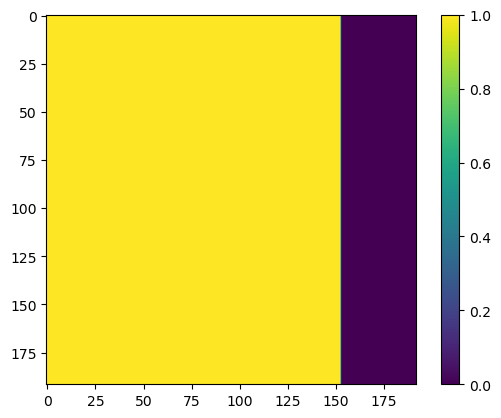

In [206]:
x = torch.randn(3, 768, 256)
x[0, 600:, :]=0
res = encoder(x)
print(res[0])

loss, hat, binary = model(x, masking_ratio=0.75, return_preds=True)

print(loss)

In [ ]:
new_mask = create_attention_mask_from_padding(x)[0]
# new_mask = new_mask.unsqueeze(1)

p2d = (10,0, 0, 10)

res = F.pad((new_mask[None, :]).to(torch.int), p2d, "replicate", 0).to(torch.bool)

plt.imshow(res[0])
print(res.shape)

tensor([[-0.5612,  0.0926,  1.8405,  ...,  0.3960,  0.0213, -0.7288],
        [-0.5617,  0.0836,  1.8530,  ...,  0.3962,  0.0192, -0.7206],
        [-0.5660,  0.0904,  1.8564,  ...,  0.3985,  0.0316, -0.7168],
        ...,
        [-0.5548, -0.0663,  1.9987,  ...,  0.5928,  0.2119, -0.7140],
        [-0.5422, -0.0745,  1.9871,  ...,  0.6059,  0.2068, -0.7229],
        [-0.5333, -0.0877,  1.9877,  ...,  0.6092,  0.2053, -0.7278]],
       grad_fn=<SelectBackward0>)
attn_mask_unmasked torch.Size([3, 1, 192, 192]) tensor([[[ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         ...,
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False],
         [ True,  True,  True,  ..., False, False, False]]])
TOKENS AFTER ENCODER tensor([[-0.4848,  0.4451,  1.6810,  ...,  0.1693, -0.0746, -0.0506],
        [-0.3261,  0.39

RuntimeError: shape mismatch: value tensor of shape [3, 196, 256] cannot be broadcast to indexing result of shape [3, 192, 256]

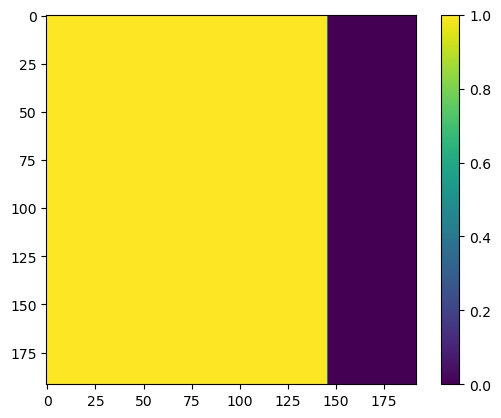

In [200]:
x = torch.randn(3, 768, 256)
x[0, 600:, :]=0
res = encoder(x)
print(res[0])

loss, hat, binary = model(x, masking_ratio=0.75, return_preds=True)

print(loss)

In [82]:
x = torch.ones(16, 500, 256)
x[0, -100:] = 0
aa
attn_mask = torch.ones(500, 500).to(torch.bool)
attn_mask = attn_mask.expand(16, -1, -1)

attn_mask = create_attention_mask_from_padding(x)

plt.imshow(attn_mask[0])

NameError: name 'aa' is not defined

torch.Size([16, 500, 500])

In [ ]:
import torch



# # Example usage
# batch_size, seq_length, feature_dim = 16, 500, 256
# x = torch.ones(batch_size, seq_length, feature_dim)
# x[0, -100:] = 0  # Pad the last 100 tokens of the first sequence

# # Get the updated attention mask
# attn_mask = update_attention_mask(x)

# print(attn_mask.shape)  # Output the shape of the updated mask to verify


In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
x = torch.ones(16, 500, 256)
x[0, -100:] = 0  # Pad the last 100 tokens of the first sequence

is_padded = (x == 0).all(dim=2)

batch_range = torch.arange(16, device=x.device)[:, None]
num_masked = 100
rand_indices = torch.rand(16, 500, device = x.device).argsort(dim=-1) # get idxs of random values.
masked_indices, unmasked_indices = rand_indices[:, :num_masked], rand_indices[:, num_masked:]

mask_valid = ~is_padded[batch_range, masked_indices]
valid_masked_indices = masked_indices[mask_valid]

In [ ]:
tokens_pred_masked = x[batch_range, masked_indices]
tokens_real_masked = x[batch_range, masked_indices]

# #let's calculate loss on masked and not padded tokens.
mask_valid = ~is_padded[batch_range, masked_indices]
loss_tensor = F.mse_loss(tokens_pred_masked, tokens_real_masked, reduction='none')
loss_real_values = loss_tensor[mask_valid.nonzero(as_tuple=True)]
recon_loss = torch.mean(loss_real_values)